# Surface WMT over Antarctic shelf versus open ocean

In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import os
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from wmt_inert_tracer.swmt import swmt
from wmt_inert_tracer.preprocessing import preprocessing
from wmt_inert_tracer.compute import lbin_define

In [4]:
import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from plot import hovmoeller

In [5]:
outdir='/work/jet/data/interim/'

# Odiv-209, Odiv-207, Odiv-206, Odiv-200, Odiv-191, Odiv-184
rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/' 
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/' # Odiv-183, Odiv-170

subdir = 'CM4_piControl_c192_OM4p125_v7' # Odiv-209
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt3' # Odiv-207
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt2' # Odiv-206
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt1' # Odiv-200
#subdir = 'CM4_piControl_c192_OM4p125_v6' # Odiv-191
#subdir = 'CM4_piControl_c192_OM4p125_v5' # Odiv-184
#subdir = 'CM4_piControl_c192_OM4p125_v5_proto1' # Odiv-183
#subdir = 'CM4_piControl_c192_OM4p25' # Odiv-170

platfrom = 'gfdl.ncrc4-intel18-prod-openmp'

In [6]:
pp = 'ocean_monthly'
full_path = os.path.join(rootdir,subdir,platfrom,'pp',pp)+'/ts/monthly/5yr/'

In [7]:
full_path

'/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/'

In [8]:
vars_ds = xr.open_mfdataset(full_path+pp+'.*.*.nc',use_cftime=True, 
                            drop_variables=['average_DT','average_T1','average_T2'])

In [9]:
grid = xr.open_dataset(os.path.join(rootdir,subdir,platfrom,'pp',pp)+'/'+pp+'.static.nc')

In [10]:
#grid = grid.assign_coords({'xh':vars_ds.xh,'yh':vars_ds.yh,'xq':vars_ds.xq,'yq':vars_ds.yq}) # Odiv-183
#grid = grid.isel(xq=slice(1,None),yq=slice(1,None)) # Odiv-183, Odiv-170

vars_ds = vars_ds.isel(xq=slice(1,None),yq=slice(1,None)) # Odiv-206, Odiv-200, Odiv-191, Odiv-184, Odiv-183, Odiv-170
grid = grid.isel(xq=slice(None,-1),yq=slice(None,-1)) # Odiv-206, Odiv-200, Odiv-191, Odiv-184

In [11]:
ds = preprocessing(vars_ds, grid, decode_times=False, verbose=False)

In [12]:
print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])

0001-01-16 to 0090-12-16


In [13]:
# Subselect Southern Ocean
#north = -30.0
north = -60.0

ds_so = ds.drop_dims('nv').where(ds.lat<north,drop=True)

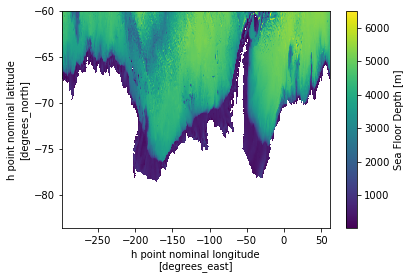

In [14]:
ds_so.deptho.plot()

In [15]:
onshlf = ds_so.where(ds_so.deptho<1000,drop=True)
offshr = ds_so.where(ds_so.deptho>=1000,drop=True)

onshlf['time_bnds'] = ds.time_bnds
offshr['time_bnds'] = ds.time_bnds

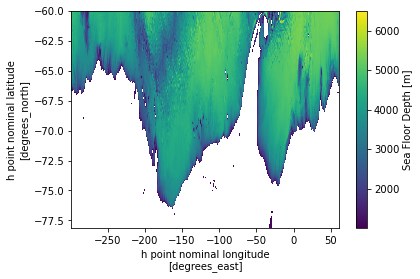

In [16]:
offshr.deptho.plot()

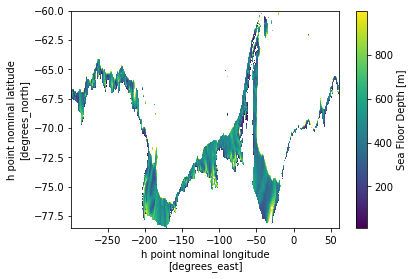

In [17]:
onshlf.deptho.plot()

In [18]:
#lstr = 'sigma0'
#dl,sigi,sigf = 0.02, 26.01 , 28.49
#dl,sigi,sigf = 0.05, 25.0 , 28.5

#lstr = 'sigma1'
#dl,sigi,sigf = 0.02, 31.01 , 33.49
#dl,sigi,sigf = 0.05, 30.0 , 33.5
#dl,sigi,sigf = 0.3, 31.55 , 32.15

lstr = 'sigma2'
dl,sigi,sigf = 0.02, 35.41, 37.89
#dl,sigi,sigf = 0.05, 34.0 , 38.0
#dl,sigi,sigf = 0.125, 34.0625 , 36.8125

lbins = lbin_define(sigi,sigf,dl)

In [19]:
# Initialize 2D surface WMT class
if 'lev' in list(ds.dims.keys()):
    dd_srf_onshlf = swmt(onshlf.drop_dims(['lev','lev_outer']))
    dd_srf_offshr = swmt(offshr.drop_dims(['lev','lev_outer']))
else:
    dd_srf_onshlf = swmt(onshlf)
    dd_srf_offshr = swmt(offshr)

In [20]:
dsG_onshlf = dd_srf_onshlf.G(lstr, bins=lbins).to_dataset(name='onshlf').reset_coords(drop=True)

In [21]:
dsG_offshr = dd_srf_offshr.G(lstr, bins=lbins).to_dataset(name='offshr').reset_coords(drop=True)

In [22]:
dsG = xr.merge([dsG_onshlf,dsG_offshr])

In [23]:
dsG = dsG.sel(time=slice('0060',None))

In [24]:
dsG

<xarray.Dataset>
Dimensions:  (time: 372, sigma2: 124)
Coordinates:
  * time     (time) object 0060-01-16 12:00:00 ... 0090-12-16 12:00:00
  * sigma2   (sigma2) float64 35.41 35.43 35.45 35.47 ... 37.83 37.85 37.87
Data variables:
    onshlf   (time, sigma2) float64 dask.array<chunksize=(1, 124), meta=np.ndarray>
    offshr   (time, sigma2) float64 dask.array<chunksize=(1, 124), meta=np.ndarray>

In [25]:
var = 'swmt' # wmt, swmt
dl_str = str(dl).replace('.','').ljust(3, '0')
fname = subdir+'_so_%sto%s_southof%sS_%s_onvoffshelf_%s_%s.nc'\
        %(str(dsG.time.dt.year[0].values).rjust(4, '0'),
          str(dsG.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''), var, lstr, dl_str)
print('Saving to file:', fname)
with ProgressBar():
    dsG.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v7_so_0060to0090_southof600S_swmt_onvoffshelf_sigma2_002.nc
[########################################] | 100% Completed |  4min  1.4s


In [26]:
dsG = xr.concat([xr.open_dataset(outdir+'CM4_piControl_c192_OM4p125_v7_so_0001to0060_southof600S_swmt_onvoffshelf_sigma2_002.nc'),
                 xr.open_dataset(outdir+fname).sel(time=slice('0061',None))],dim='time')

fname = subdir+'_so_%sto%s_southof%sS_%s_onvoffshelf_%s_%s.nc'\
        %(str(dsG.time.dt.year[0].values).rjust(4, '0'),
          str(dsG.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''), var, lstr, dl_str)
print('Saving to file:', fname)
dsG.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v7_so_0001to0090_southof600S_swmt_onvoffshelf_sigma2_002.nc


In [27]:
yr_st,yr_ed = '0081','0090'
dsG = xr.open_dataset(outdir+fname).sel(time=slice(yr_st,yr_ed))

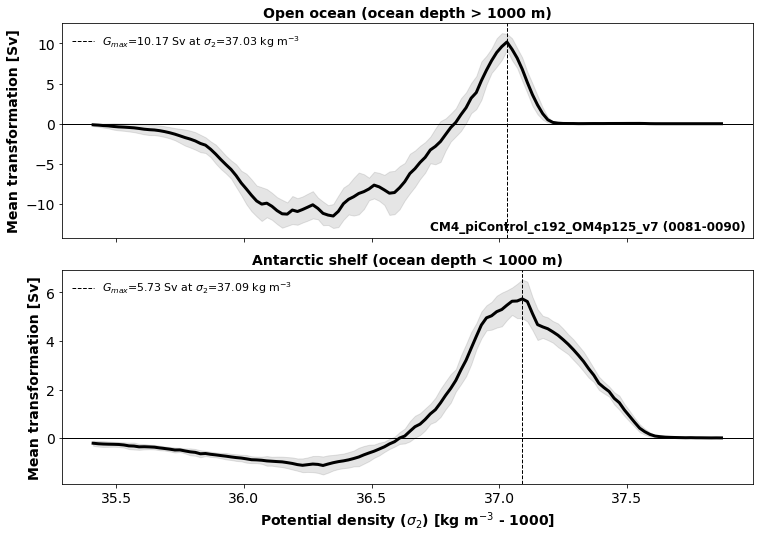

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(12,8))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.15)
for i, reg in enumerate(['offshr','onshlf']):
    axs[i].axhline(y=0, xmin=0, xmax=1, c = 'k', lw=1.0, ls='-')
    axs[i].fill_between(dsG.coords[lstr], 
                        (dsG[reg].mean('time')-dsG[reg].groupby('time.year').mean('time').std('year'))*1e-6, 
                        (dsG[reg].mean('time')+dsG[reg].groupby('time.year').mean('time').std('year'))*1e-6, 
                        alpha=0.1, edgecolor='k', facecolor='k')
    axs[i].plot(dsG.coords[lstr], dsG[reg].mean('time')*1e-6, lw=3, c='k', ls='-',label=None)
    sig_max = np.round(dsG[reg].mean('time')[dsG[reg].mean('time').argmax()][lstr].values,2)
    G_max = np.round(dsG[reg].mean('time')[dsG[reg].mean('time').argmax()].values*1e-6,2)
    axs[i].axvline(x=sig_max, c = 'k', ls='--', lw=1, 
                   label=r'$G_{max}$=%.2f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(G_max,lstr[-1],sig_max))
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].set_ylabel('Mean transformation [Sv]',fontsize=14,fontweight='bold')
    axs[i].legend(loc='upper left', ncol=1, fontsize=11,frameon=False)
    
axs[0].set_xticklabels([])
axs[0].set_title('Open ocean (ocean depth > 1000 m)', fontsize=14, fontweight='bold')
axs[1].set_title('Antarctic shelf (ocean depth < 1000 m)', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Potential density ($\sigma_%s$) [kg m$^{-3}$ - 1000]'%lstr[-1],fontsize=14,fontweight='bold')
axs[0].text(0.99, 0.02, subdir+' (%s-%s)'%(yr_st,yr_ed), ha='right', va='bottom', fontsize=12, 
            fontweight='bold',transform=axs[0].transAxes)
plt.show()

In [29]:
ddict = {mod:{} for mod in ['a','b']}
ddict['a'] = xr.open_dataset(outdir+fname).sel(time=slice('0031','0040'))
ddict['b'] = xr.open_dataset(outdir+fname).sel(time=slice(yr_st,yr_ed))

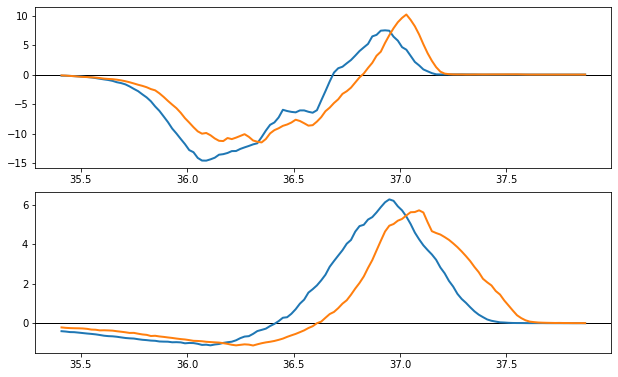

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.15)
for i, reg in enumerate(['offshr','onshlf']):
    axs[i].axhline(y=0, xmin=0, xmax=1, c = 'k', lw=1.0, ls='-')
    for j, mod in enumerate(ddict):
        dsG = ddict[mod]
        axs[i].plot(dsG.coords[lstr], dsG[reg].mean('time')*1e-6, lw=2)
plt.show()

In [31]:
dsG = xr.open_dataset(outdir+fname)

G_ann = dsG.groupby('time.year').mean('time')*1e-6
G_anom = G_ann - G_ann.mean('year')

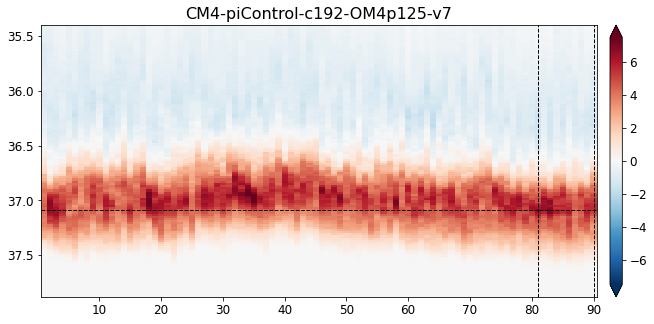

In [32]:
fig = hovmoeller(G_ann['onshlf'], fsize=[12, 5], cmap='RdBu_r', yincrease=False,#xlimrange=[None, 71], 
                 vrange=[-7.5,7.5],vline=[int(yr_st),int(yr_ed)], hline=[sig_max],title=subdir.replace('_', '-'))

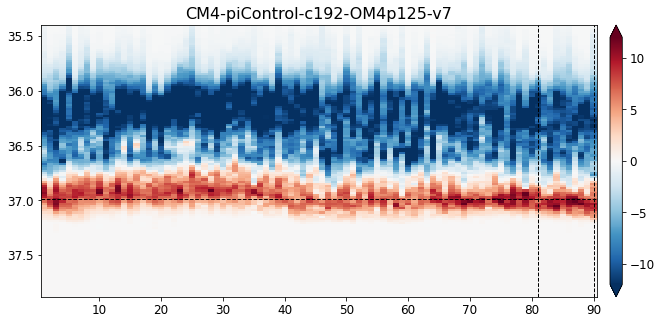

In [33]:
fig = hovmoeller(G_ann['offshr'], fsize=[12, 5], cmap='RdBu_r', yincrease=False,#xlimrange=[None, 71], 
                 vrange=[-12,12],vline=[int(yr_st),int(yr_ed)], hline=[36.99],title=subdir.replace('_', '-'))

## Decompose surface WMT

In [34]:
dsG_onshlf = dd_srf_onshlf.G(lstr, bins=lbins, group_tend=False)
dsG_onshlf['total'] = dsG_onshlf.heat+dsG_onshlf.salt

dsG_offshr = dd_srf_offshr.G(lstr, bins=lbins, group_tend=False)
dsG_offshr['total'] = dsG_offshr.heat+dsG_offshr.salt

In [35]:
for vstr in list(dsG_onshlf.data_vars):
    dsG_onshlf = dsG_onshlf.rename({vstr:'onshlf_'+vstr})
    dsG_offshr = dsG_offshr.rename({vstr:'offshr_'+vstr})
dsG = xr.merge([dsG_onshlf,dsG_offshr])

In [36]:
dsG = dsG.sel(time=slice('0060',None))

In [37]:
var = 'swmt' # wmt, swmt
dl_str = str(dl).replace('.','').ljust(3, '0')
fname = subdir+'_so_%sto%s_southof%sS_%s_onvoffshelf_decomposed_%s_%s.nc'\
        %(str(dsG.time.dt.year[0].values).rjust(4, '0' ),
          str(dsG.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''), var, lstr, dl_str)
print('Saving to file:', fname)
with ProgressBar():
    dsG.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v7_so_0060to0090_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
[########################################] | 100% Completed |  4min  0.8s


In [38]:
dsG = xr.concat([xr.open_dataset(outdir+'CM4_piControl_c192_OM4p125_v7_so_0001to0060_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc'),
                 xr.open_dataset(outdir+fname).sel(time=slice('0061',None))],dim='time')

In [39]:
fname = subdir+'_so_%sto%s_southof%sS_%s_onvoffshelf_decomposed_%s_%s.nc'\
        %(str(dsG.time.dt.year[0].values).rjust(4, '0' ),
          str(dsG.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''), var, lstr, dl_str)
print('Saving to file:', fname)
dsG.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v7_so_0001to0090_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc


In [40]:
#yr_st,yr_ed = '0191','0200'
dsG = xr.open_dataset(outdir+fname).sel(time=slice(yr_st,yr_ed))
G_mean = dsG.mean('time')*1e-6
G_std = dsG.groupby('time.year').mean('time').std('year')*1e-6

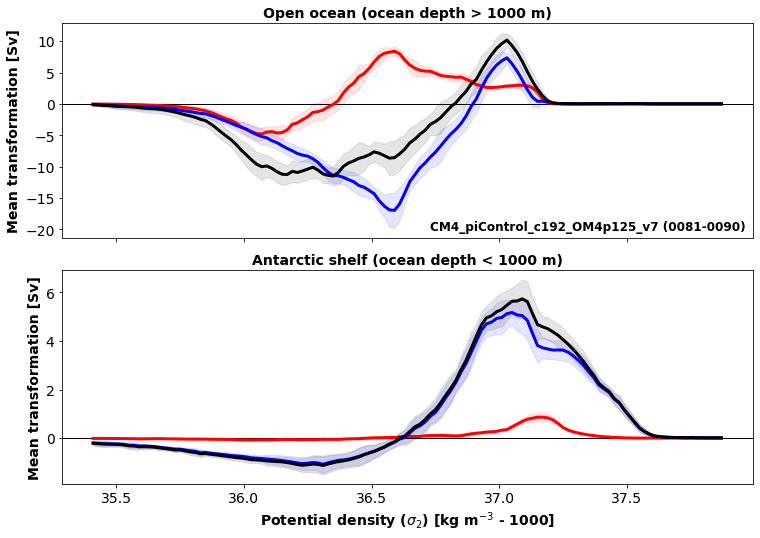

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(12,8))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.15)
cs = ['r','b','k']
for i, reg in enumerate(['offshr','onshlf']):
    
    axs[i].axhline(y=0, xmin=0, xmax=1, c = 'k', lw=1.0, ls='-')
    
    for j, ten in enumerate(['heat','salt','total']):
        axs[i].fill_between(dsG.coords[lstr], G_mean[reg+'_'+ten]-G_std[reg+'_'+ten], 
                            G_mean[reg+'_'+ten]+G_std[reg+'_'+ten], alpha=0.1, edgecolor=cs[j], facecolor=cs[j])
        axs[i].plot(dsG.coords[lstr], G_mean[reg+'_'+ten], lw=3, c=cs[j], ls='-',label=None)
        
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].set_ylabel('Mean transformation [Sv]',fontsize=14,fontweight='bold')
    
axs[0].set_xticklabels([])
axs[0].set_title('Open ocean (ocean depth > 1000 m)', fontsize=14, fontweight='bold')
axs[1].set_title('Antarctic shelf (ocean depth < 1000 m)', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Potential density ($\sigma_%s$) [kg m$^{-3}$ - 1000]'%lstr[-1],fontsize=14,fontweight='bold')
axs[0].text(0.99, 0.02, subdir+' (%s-%s)'%(yr_st,yr_ed), ha='right', va='bottom', fontsize=12, 
            fontweight='bold',transform=axs[0].transAxes)
plt.show()

In [42]:
dsG = xr.open_dataset(outdir+fname)

G_ann = dsG.groupby('time.year').mean('time')*1e-6
G_anom = G_ann - G_ann.mean('year')

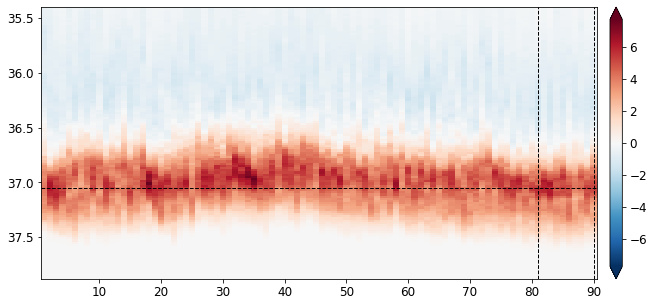

In [43]:
fig = hovmoeller(G_ann.onshlf_salt, fsize=[12, 5], cmap='RdBu_r', yincrease=False, vline=[int(yr_st),int(yr_ed)], hline=[37.05])

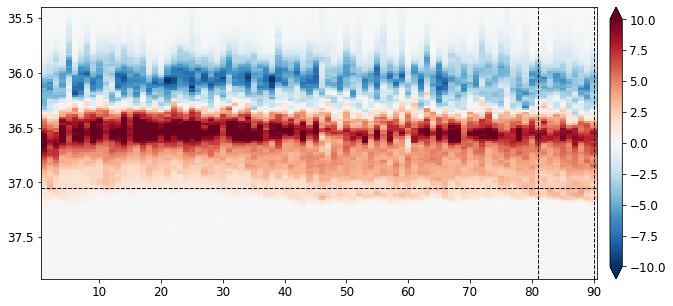

In [44]:
fig = hovmoeller(G_ann.offshr_heat, fsize=[12, 5], cmap='RdBu_r', yincrease=False, vline=[int(yr_st),int(yr_ed)], 
                 hline=[37.05], vrange = [-10,10])

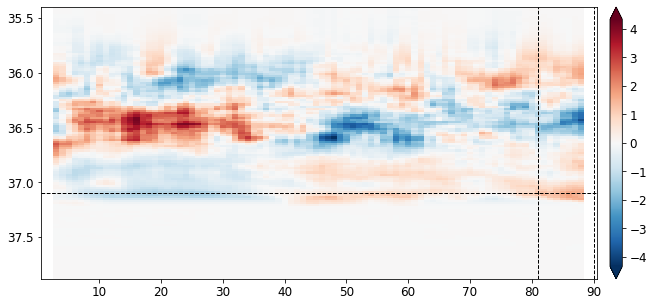

In [45]:
fig = hovmoeller(G_anom.offshr_heat.rolling(year=5,center=True).mean(), fsize=[12, 5], cmap='RdBu_r', yincrease=False,
                 vline=[int(yr_st),int(yr_ed)], hline=[37.1])

## Decompose surface WMT by mass (fw) and salt fluxes

In [23]:
dsG_onshlf_mass = dd_srf_onshlf.G(lstr, bins=lbins, decompose='mass')
dsG_onshlf_salt = dd_srf_onshlf.G(lstr, bins=lbins, decompose='salt')

dsG_offshr_mass = dd_srf_offshr.G(lstr, bins=lbins, decompose='mass')
dsG_offshr_salt = dd_srf_offshr.G(lstr, bins=lbins, decompose='salt')

In [24]:
dsG_onshlf = xr.merge([dsG_onshlf_mass.rename({'total':'total_mass'}),dsG_onshlf_salt[['basal_salt']]])
dsG_offshr = xr.merge([dsG_offshr_mass.rename({'total':'total_mass'}),dsG_offshr_salt[['basal_salt']]])

In [25]:
for vstr in list(dsG_onshlf.data_vars):
    dsG_onshlf = dsG_onshlf.rename({vstr:'onshlf_'+vstr})
    dsG_offshr = dsG_offshr.rename({vstr:'offshr_'+vstr})
dsG = xr.merge([dsG_onshlf,dsG_offshr])

In [30]:
var = 'swmt' # wmt, swmt
dl_str = str(dl).replace('.','').ljust(3, '0')

for v in dsG.keys():
    fname = subdir+'_so_%sto%s_southof%sS_%s_onvoffshelf_decomposed_haline_%s_%s_%s.nc'\
                %(str(dsG.time.dt.year[0].values).rjust(4, '0' ),
                  str(dsG.time.dt.year[-1].values).rjust(4, '0'),
                  str(abs(north)).replace('.',''), var, v, lstr, dl_str)
    print('Saving to file:', fname)
#    with ProgressBar():
#        dsG[v].to_dataset(name=v).reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_haline_onshlf_total_mass_sigma2_002.nc
Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_haline_onshlf_rain_and_ice_sigma2_002.nc
Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_haline_onshlf_snow_sigma2_002.nc
Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_haline_onshlf_evaporation_sigma2_002.nc
Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_haline_onshlf_rivers_sigma2_002.nc
Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_haline_onshlf_icebergs_sigma2_002.nc
Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_haline_onshlf_basal_salt_sigma2_002.nc
S

In [31]:
fnames = subdir+'_so_%sto%s_southof%sS_%s_onvoffshelf_decomposed_haline_*_%s_%s.nc'\
                %(str(dsG.time.dt.year[0].values).rjust(4, '0' ),
                  str(dsG.time.dt.year[-1].values).rjust(4, '0'),
                  str(abs(north)).replace('.',''), var, lstr, dl_str)
dsG = xr.open_mfdataset(outdir+fnames)

In [82]:
var = 'swmt' # wmt, swmt
dl_str = str(dl).replace('.','').ljust(3, '0')
fname = subdir+'_so_%sto%s_southof%sS_%s_onvoffshelf_decomposed_haline_%s_%s.nc'\
        %(str(dsG.time.dt.year[0].values).rjust(4, '0' ),
          str(dsG.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''), var, lstr, dl_str)
print('Saving to file:', fname)
#with ProgressBar():
#    dsG.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_haline_sigma2_002.nc


In [83]:
dsG = xr.open_dataset(outdir+fname)

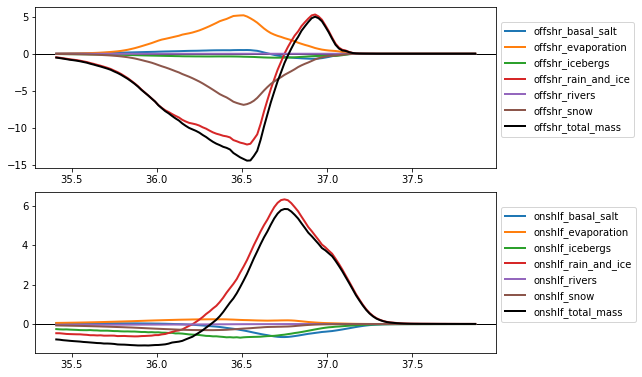

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(8,6))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.15)

for i, reg in enumerate(['offshr','onshlf']):
    axs[i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
    for v in dsG.keys():
        if v[:6] == reg:
            if v.split('_')[1] != 'total':
                axs[i].plot(dsG[lstr], dsG[v].mean('time')*1e-6, lw=2, linestyle='-', label=v)
            else:
                axs[i].plot(dsG[lstr], dsG[v].mean('time')*1e-6, lw=2, linestyle='-', c = 'k', label=v)
    axs[i].legend(loc='center left',bbox_to_anchor=(1, 0.55))
plt.show()

In [73]:
reg = 'onshlf' # offshr, onshlf
G = xr.Dataset(data_vars={})    
for v in dsG.keys():
    if v[:6] == reg:
        G[v[7:]] = dsG[v]
        
G = G.drop_vars('basal_salt').rename({'total_mass':'total'}).sel(time=slice(yr_st,yr_ed))

In [74]:
sum_of_components = xr.zeros_like(G.total)
components = [v for v in G.keys() if v != 'total']
for v in components:
    sum_of_components += G[v]

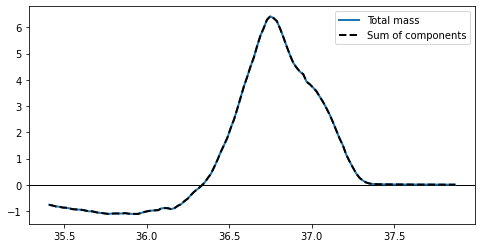

In [75]:
fig, ax = plt.subplots(figsize=(8,4))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(G[lstr], G['total'].mean('time')*1e-6, lw=2, linestyle='-', label='Total mass')
ax.plot(G[lstr], sum_of_components.mean('time')*1e-6, color='k', lw=2, linestyle='--', label='Sum of components')
ax.legend()
plt.show()

In [37]:
G_ann = dsG.groupby('time.year').mean('time')*1e-6

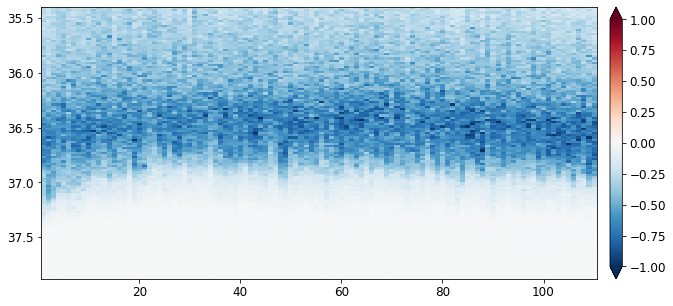

In [38]:
fig = hovmoeller(G_ann.onshlf_icebergs, fsize=[12, 5], cmap='RdBu_r', yincrease=False, vrange=[-1,1])

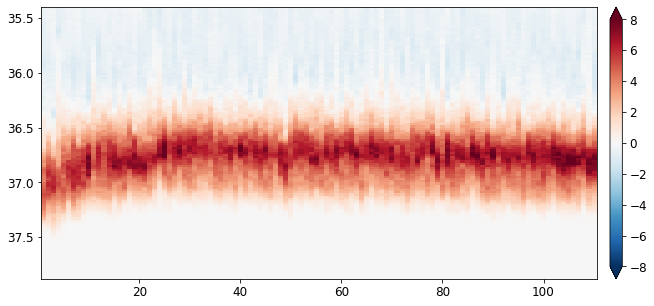

In [39]:
fig = hovmoeller(G_ann.onshlf_rain_and_ice, fsize=[12, 5], cmap='RdBu_r', yincrease=False, vrange=[-8,8])

In [86]:
fnameb = 'CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc'
reg = 'offshr' # offshr, onshlf

ddict = {mod:{} for mod in ['a','b']}
ddict['a'] = dsG[reg+'_total_mass'] + dsG[reg+'_basal_salt']
ddict['b'] = xr.open_dataset(outdir+fnameb)[reg+'_salt']

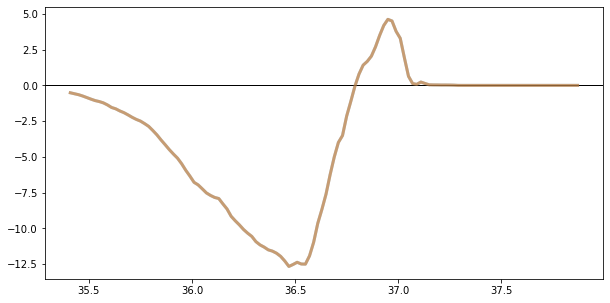

In [87]:
yr_st,yr_ed = '0081','0100'

fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')

for mod in ddict:
    ax.plot(ddict[mod][lstr], ddict[mod].sel(time=slice(yr_st,yr_ed)).mean('time')*1e-6, lw=3, alpha=0.5)
plt.show()

## Decompose surface WMT by heat fluxes

In [45]:
dsG_onshlf = dd_srf_onshlf.G(lstr, bins=lbins, decompose='heat')
dsG_offshr = dd_srf_offshr.G(lstr, bins=lbins, decompose='heat')

In [46]:
for vstr in list(dsG_onshlf.data_vars):
    dsG_onshlf = dsG_onshlf.rename({vstr:'onshlf_'+vstr})
    dsG_offshr = dsG_offshr.rename({vstr:'offshr_'+vstr})
dsG = xr.merge([dsG_onshlf,dsG_offshr])

In [47]:
var = 'swmt' # wmt, swmt
dl_str = str(dl).replace('.','').ljust(3, '0')

for v in dsG.keys():
    fname = subdir+'_so_%sto%s_southof%sS_%s_onvoffshelf_decomposed_thermal_%s_%s_%s.nc'\
                %(str(dsG.time.dt.year[0].values).rjust(4, '0' ),
                  str(dsG.time.dt.year[-1].values).rjust(4, '0'),
                  str(abs(north)).replace('.',''), var, v, lstr, dl_str)
    print('Saving to file:', fname)
    with ProgressBar():
        dsG[v].to_dataset(name=v).reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_thermal_onshlf_total_sigma2_002.nc
[########################################] | 100% Completed | 10min  6.7s
Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_thermal_onshlf_latent_sigma2_002.nc
[########################################] | 100% Completed |  9min 57.4s
Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_thermal_onshlf_sensible_sigma2_002.nc
[########################################] | 100% Completed |  9min 49.7s
Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_thermal_onshlf_longwave_sigma2_002.nc
[########################################] | 100% Completed |  9min 43.4s
Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_thermal_onshlf_shortwave_sigma2_

In [48]:
fnames = subdir+'_so_%sto%s_southof%sS_%s_onvoffshelf_decomposed_thermal_*_%s_%s.nc'\
                %(str(dsG.time.dt.year[0].values).rjust(4, '0' ),
                  str(dsG.time.dt.year[-1].values).rjust(4, '0'),
                  str(abs(north)).replace('.',''), var, lstr, dl_str)
dsG = xr.open_mfdataset(outdir+fnames)

In [76]:
var = 'swmt' # wmt, swmt
dl_str = str(dl).replace('.','').ljust(3, '0')
fname = subdir+'_so_%sto%s_southof%sS_%s_onvoffshelf_decomposed_thermal_%s_%s.nc'\
        %(str(dsG.time.dt.year[0].values).rjust(4, '0' ),
          str(dsG.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''), var, lstr, dl_str)
print('Saving to file:', fname)
#with ProgressBar():
#    dsG.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_thermal_sigma2_002.nc


In [77]:
dsG = xr.open_dataset(outdir+fname)

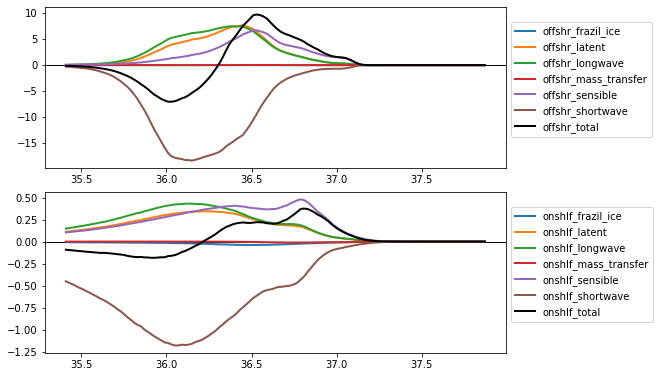

In [51]:
fig, axs = plt.subplots(2, 1, figsize=(8,6))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.15)

for i, reg in enumerate(['offshr','onshlf']):
    axs[i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
    for v in dsG.keys():
        if v[:6] == reg:
            if v.split('_')[1] != 'total':
                axs[i].plot(dsG[lstr], dsG[v].mean('time')*1e-6, lw=2, linestyle='-', label=v)
            else:
                axs[i].plot(dsG[lstr], dsG[v].mean('time')*1e-6, lw=2, linestyle='-', c = 'k', label=v)
    axs[i].legend(loc='center left',bbox_to_anchor=(1, 0.55))
plt.show()

In [78]:
reg = 'offshr' # offshr, onshlf
G = xr.Dataset(data_vars={})    
for v in dsG.keys():
    if v[:6] == reg:
        G[v[7:]] = dsG[v]

G = G.sel(time=slice(yr_st,yr_ed))

In [79]:
sum_of_components = xr.zeros_like(G.total)
components = [v for v in G.keys() if v != 'total']
for v in components:
    sum_of_components += G[v]

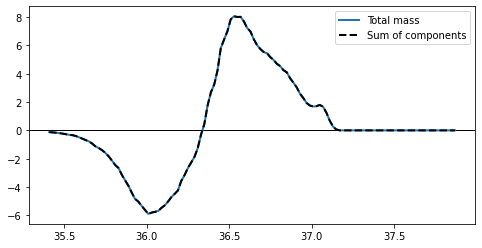

In [80]:
fig, ax = plt.subplots(figsize=(8,4))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(G[lstr], G['total'].mean('time')*1e-6, lw=2, linestyle='-', label='Total mass')
ax.plot(G[lstr], sum_of_components.mean('time')*1e-6, color='k', lw=2, linestyle='--', label='Sum of components')
ax.legend()
plt.show()

In [59]:
G_ann = dsG.groupby('time.year').mean('time')*1e-6

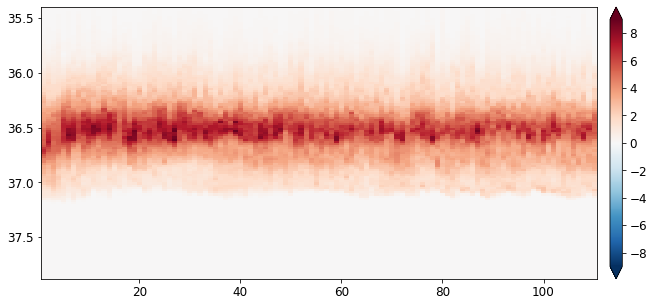

In [60]:
fig = hovmoeller(G_ann.offshr_sensible, fsize=[12, 5], cmap='RdBu_r', yincrease=False, vrange=[-9,9])

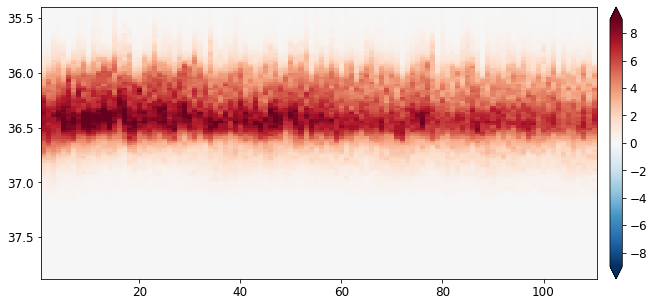

In [61]:
fig = hovmoeller(G_ann.offshr_latent, fsize=[12, 5], cmap='RdBu_r', yincrease=False, vrange=[-9,9])

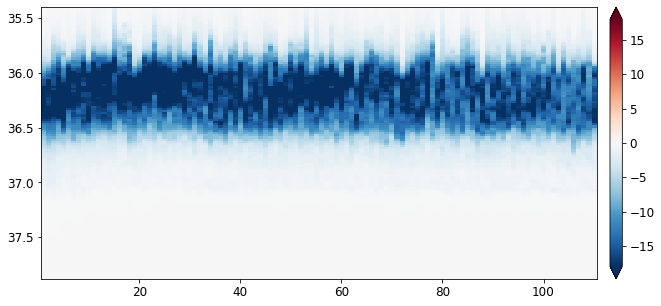

In [62]:
fig = hovmoeller(G_ann.offshr_shortwave, fsize=[12, 5], cmap='RdBu_r', yincrease=False, vrange=[-18,18])

In [65]:
fnameb = 'CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc'
reg = 'onshlf' # offshr, onshlf

ddict = {mod:{} for mod in ['a','b']}
ddict['a'] = dsG[reg+'_total']
ddict['b'] = xr.open_dataset(outdir+fnameb)[reg+'_heat']

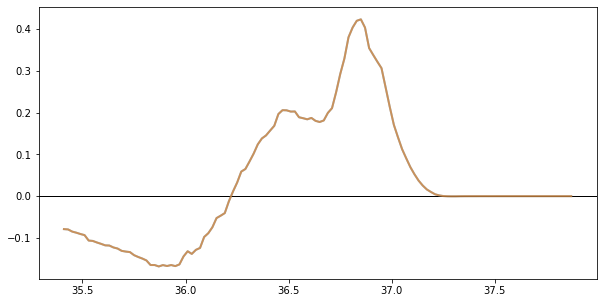

In [66]:
#yr_st,yr_ed = '0081','0100'

fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')

for mod in ddict:
    ax.plot(ddict[mod][lstr], ddict[mod].sel(time=slice(yr_st,yr_ed)).mean('time')*1e-6, lw=2, alpha=0.6)
    
plt.show()

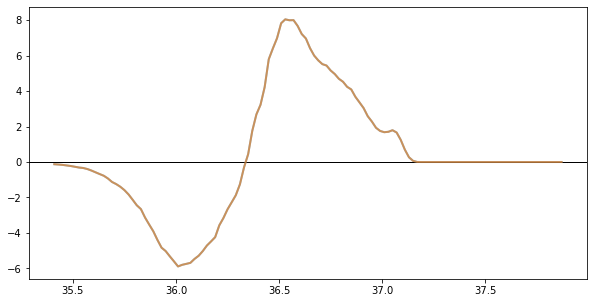